## Import

In [1]:
#%reset

# import libraries
import sympy as sym
import numpy as np
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

#sym.init_printing()
from IPython.display import display

## Basic model limits

In [2]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
m = ConcreteModel() # create model using pyomo
N = 50 # number of nodes (much like samples used between a certain time period)
kN = 25
hm = 1 #0.5/N # I think this is the time step

m.N = RangeSet(N)
m.kN = RangeSet(kN)

mass_b = 2 # Mass of the base
mass_l = 0.3 # Mass of the links
len_b = 0.3 # Length of the base
len_l = 0.2

m.damping = 60
m.l_min = 0.0 # Links min length
m.l_max = len_l # Links max length
m.F_max = 160 # Maximum force that can be applied
m.t_max = 12 # Maximum torque
m.w_max = 44 # Max angular velocity (omega)
m.dl_max = 3
m.distance = 3

## EoM generation

In [3]:
# create symbolic variables
g = sym.symbols('g')
mb, ml1, ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb, ll1, ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb, Inl1, Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,z,thb,thl,r = sym.symbols(['x','z','\\theta_{body}','\\theta_{leg}','r'])
dx,dz,dthb,dthl,dr = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{body}','\dot{\\theta}_{leg}','\dot{r}']) 
ddx,ddz,ddthb,ddthl,ddr = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg}','\ddot{r}']) 

q = sym.Matrix([[x],[z],[thb],[thl],[r]])
dq = sym.Matrix([[dx],[dz],[dthb],[dthl],[dr]])
ddq = sym.Matrix([[ddx],[ddz],[ddthb],[ddthl],[ddr]])

# forces
F_pos, F_neg, F_rtn, F_ext = sym.symbols(['F_{pos}','F_{neg}','F_{rtn}','F_{ext}']) 
tau, GRFx, GRFz = sym.symbols(['\\tau','G_x','G_z']) 


# STEP 1: position vector (COM of each link), as well as other required positions. 
rb = sym.Matrix([[x],
                [z]])

rl1 = sym.Matrix([[x + (0.5*ll1)*sym.cos(thl)],
                 [z - (0.5*ll1)*sym.sin(thl)]])

rl2 = sym.Matrix([[x + (ll1 + 0.5*r)*sym.cos(thl)],
                 [z - (ll1 + 0.5*r)*sym.sin(thl)]])


footx = sym.Matrix([x + (ll1 + r)*sym.cos(thl)])
footz = sym.Matrix([z - (ll1 + r)*sym.sin(thl)]) 
footz = footz[0].simplify()
foot_pos= sym.Matrix([[footx],[0],[footz]])


# STEP 2: generate expressions for the system space velocities from the jacobians
# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

footdx = footx.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footdx = footdx[0].simplify()

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb]])
Ml1 = sym.Matrix([[ml1,ml1]])
Ml2 = sym.Matrix([[ml2,ml2]])

Ib = sym.Matrix([[Inb]])
Il1 = sym.Matrix([[Inl1]])
Il2 = sym.Matrix([[Inl2]])

Wb = sym.Matrix([[dthb]])
Wl = sym.Matrix([[dthl]])

# linear kinetic energy:
T1 = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
# angular kinetic energy:
T2 =  0.5*Ib*sym.matrix_multiply_elementwise(Wb,Wb) + 0.5*Il1*sym.matrix_multiply_elementwise(Wl,Wl) + 0.5*Il2*sym.matrix_multiply_elementwise(Wl,Wl)

T = sym.Matrix([T1[0]]) + sym.Matrix([T2[0]])


# potential energy
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

J=foot_pos.jacobian(q)
GRF_l = J.transpose()*sym.Matrix([[GRFx],[0],[GRFz]])   

Q = sym.zeros(len(q),1)
Q[0] = 0                                                        #X
Q[1] = 0                                                        #Z
Q[2] = -tau                                                     #thb
Q[3] = tau                                                      #thl
Q[4] = m.F_max*(F_pos - F_neg) - dr*m.damping + F_rtn - F_ext   #r
           
EOM = M*ddq + C*dq + G - Q - GRF_l

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
print('Done')

Done


## Lambdify

In [4]:
# Lambdify
func_map = {'sin':sin, 'cos':cos} 

sym_list = [g, mb, ml1, ml2,
            lb, ll1, ll2, 
            Inb, Inl1, Inl2,
            x, z, thb, thl, r,
            dx, dz, dthb, dthl, dr,
            ddx, ddz, ddthb, ddthl, ddr,
            F_pos, F_neg, F_rtn, F_ext, 
            tau, GRFx, GRFz]
            
lambEOM_x   = sym.lambdify(sym_list,EOMs[0], modules = [func_map])
lambEOM_z   = sym.lambdify(sym_list,EOMs[1], modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2], modules = [func_map])
lambEOM_thl = sym.lambdify(sym_list,EOMs[3], modules = [func_map])
lambEOM_r   = sym.lambdify(sym_list,EOMs[4], modules = [func_map])

lamb_footz = sym.lambdify(sym_list,footz, modules = [func_map])
lamb_footdx = sym.lambdify(sym_list,footdx, modules = [func_map])

print('Done')

Done


## Trajectory optimization

In [5]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('body',1),('leg',1), ('leg',2)]
m.L = Set(initialize = links)

DOFs = ['x','z','theta_b','theta_l','r'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN, bounds = (0, None))
m.tt0 = Var(m.N)


m.h = Var(m.N, bounds =(0.01, 0.1))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]

In [6]:
# PARAMETERS-----------------------------------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81)
pi=sym.pi

m.mb = Param(initialize = mass_b)
m.ml1 = Param(initialize = mass_l)
m.ml2 = Param(initialize = mass_l)

m.lb = Param(initialize = len_b)
m.ll1 = Param(initialize = len_l)
m.ll2 = Param(initialize = len_l)

m.Inb = Param(initialize = 5*m.mb.value*m.lb.value**2/12)   
m.Inl1 = Param(initialize = 5*m.ml1.value*m.ll1.value**2/12)  ##############################m.ml.value*m.q[m.n,m.cN,'r']**2/12
m.Inl2 = Param(initialize = 5*m.ml2.value*m.ll2.value**2/12)

mbody = m.mb + m.ml1 + m.ml2
BW = mbody*m.g.value

print('done')

done


#### Collocation constraints

In [7]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('done')

done


In [8]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('done')

done


#### GRF stuff

In [9]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X', 'Z','THETA']
m.WDOF = Set(initialize = WDOFs) #change the coordinates
m.GRF = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0, None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize = 1000, mutable = True)
m.mu = Param(initialize = 1)

print('done')

done


In [10]:
# SLACK VARIABLES
m.a_contact_1  = Var(m.N, m.cN, bounds = (0, None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0, None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0, None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0, None)) 
m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0, None)) 
m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0, None)) 
m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0, None)) 
m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0, None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0, None)) 

print('done')

done


In [11]:
# CONTACT
def def_a_contact_1(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                0, 0, 0, 0,
                0, 0, 0]
    return m.a_contact_1[n,c] == lamb_footz(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)

def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

print('done')

done


In [12]:
# FRICTION CONE
def def_a_friction_1(m,n,c):   
    return m.a_friction_1[n,c] == m.mu*m.GRF[n,c,'Z','ps'] - (m.GRF[n,c,'X','ps'] + m.GRF[n,c,'X','ng'])
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)

def def_b_friction_1(m,n,c):   
    return m.b_friction_1[n,c] == m.gamma_1[n,c]
m.def_b_friction_1 = Constraint(m.N, m.cN, rule = def_b_friction_1)

print('done')

done


In [13]:
#SLIP POS DIR
def def_a_slip_p_1(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                0, 0, 0, 0,
                0, 0, 0]
    return m.a_slip_p_1[n,c] ==m.gamma_1[n,c]+lamb_footdx(*var_list)
m.def_a_slip_p_1 = Constraint(m.N, m.cN, rule = def_a_slip_p_1)

def def_b_slip_p_1(m,n,c):   
    return m.b_slip_p_1[n,c] == m.GRF[n,c,'X','ps']
m.def_b_slip_p_1 = Constraint(m.N, m.cN, rule = def_b_slip_p_1)


# SLIP NEG DIR
def def_a_slip_n_1(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                0, 0, 0, 0,
                0, 0, 0]
    return m.a_slip_n_1[n,c] ==m.gamma_1[n,c]-lamb_footdx(*var_list)
m.def_a_slip_n_1 = Constraint(m.N, m.cN, rule = def_a_slip_n_1)

def def_b_slip_n_1(m,n,c):   
    return m.b_slip_n_1[n,c] == m.GRF[n,c,'X','ng']
m.def_b_slip_n_1 = Constraint(m.N, m.cN, rule = def_b_slip_n_1)

print('done')

done


In [14]:
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

def def_friction_1_pr(m,n):
    a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
    b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
    return a_friction_1_pr*b_friction_1_pr <= m.eps
m.def_friction_1_pr = Constraint(m.N, rule = def_friction_1_pr)

def def_slip_p_1_pr(m,n):
    a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
    b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
    return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
m.def_slip_p_1_pr = Constraint(m.N, rule = def_slip_p_1_pr)

def def_slip_n_1_pr(m,n):
    a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
    b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
    return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps
m.def_slip_n_1_pr = Constraint(m.N, rule = def_slip_n_1_pr)

print('done')

done


#### Motor model

In [15]:
m.tau_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip

m.Fbang_pos = Var(m.N, bounds = (0, 1)) # actuator prismatic force
m.Fbang_neg = Var(m.N, bounds = (0, 1)) # actuator prismatic force
m.FhardStop_ext = Var(m.N, bounds = (0, 1.5*m.F_max))
m.FhardStop_rtn = Var(m.N, bounds = (0, 1.5*m.F_max))
m.kSlack_pos = Var(m.kN, bounds = (0, 1)) # bucket node slack variable
m.kSlack_neg = Var(m.kN, bounds = (0, 1)) # bucket node slack variable 

print('done')

done


In [16]:
def def_hip_motor_model_p(m,n):
    return  m.tau_a[n] <= m.t_max - m.t_max/m.w_max*(m.dq0[n,'theta_l'] - m.dq0[n,'theta_b'])
m.def_hip_motor_model_p = Constraint(m.N, rule = def_hip_motor_model_p)

def def_hip_motor_model_n(m,n):
    return  m.tau_a[n] >= -m.t_max - m.t_max/m.w_max*(m.dq0[n,'theta_l'] - m.dq0[n,'theta_b'])
m.def_hip_motor_model_n = Constraint(m.N, rule = def_hip_motor_model_n)

def pneumaticsPos(m, kn):
    return ((1 - m.kSlack_pos[kn])*(m.kSlack_pos[kn])) <= m.eps 
m.pneumaticsPos = Constraint(m.kN,  rule = pneumaticsPos)

def pneumaticsNeg(m, kn):
    return ((1 - m.kSlack_neg[kn])*(m.kSlack_neg[kn])) <= m.eps  
m.pneumaticsNeg = Constraint(m.kN,  rule = pneumaticsNeg)

def BucketNodePos(m, n):
    interval = N/kN
    nodes = int((n-1)/interval) + 1
    if n == N:
        nodes = kN
    if(n <= N):
        return  m.Fbang_pos[n]  == m.kSlack_pos[nodes]
    else:
        return Constraint.Skip
m.BucketNodePos = Constraint(m.N, rule = BucketNodePos)

def BucketNodeNeg(m, n):
    interval = N/kN
    nodes = int((n-1)/interval) + 1
    if n == N:
        nodes = kN
    if(n <= N):
        return  m.Fbang_neg[n]  == m.kSlack_neg[nodes]
    else:
        return Constraint.Skip
m.BucketNodeNeg = Constraint(m.N, rule = BucketNodeNeg)

def pushOrPull(m, n):
    return m.Fbang_neg[n]*m.Fbang_pos[n] <= m.eps
m.pushOrPull = Constraint(m.N, rule = pushOrPull)

def extension_contact(m,n):
    if(n < N-2):
        return (m.l_max - m.q0[n+1,'r'])*(m.FhardStop_ext[n]) <= m.eps
    else:
        return m.FhardStop_ext[n] == 0
m.extension_contact = Constraint(m.N, rule = extension_contact)

def retraction_contact(m,n):
    if (n < N-2):
        return (m.q0[n+1,'r'] - m.l_min)*(m.FhardStop_rtn[n]) <= m.eps
    else:
        return m.FhardStop_rtn[n] == 0
m.retraction_contact = Constraint(m.N, rule = retraction_contact)

print('done')

done


#### EoM constraints

In [17]:
S=1.0 #BW/m.mTot    #Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    F_in_pos = S*(m.Fbang_pos[n])
    F_in_neg = S*(m.Fbang_neg[n])
    F_in_ext = S*(m.FhardStop_ext[n])
    F_in_rtn = S*(m.FhardStop_rtn[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps'] - m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                F_in_pos, F_in_neg, F_in_rtn, F_in_ext, 
                tau_in, Gx_in, Gz_in]
    
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_z(m,n,c):
    F_in_pos = S*(m.Fbang_pos[n])
    F_in_neg = S*(m.Fbang_neg[n])
    F_in_ext = S*(m.FhardStop_ext[n])
    F_in_rtn = S*(m.FhardStop_rtn[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps'] - m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                F_in_pos, F_in_neg, F_in_rtn, F_in_ext, 
                tau_in, Gx_in, Gz_in]
 
    return lambEOM_z(*var_list) == 0
m.EOM_z = Constraint(m.N, m.cN, rule = EOM_z)

def EOM_thb(m,n,c):
    F_in_pos = S*(m.Fbang_pos[n])
    F_in_neg = S*(m.Fbang_neg[n])
    F_in_ext = S*(m.FhardStop_ext[n])
    F_in_rtn = S*(m.FhardStop_rtn[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps'] - m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                F_in_pos, F_in_neg, F_in_rtn, F_in_ext, 
                tau_in, Gx_in, Gz_in]
 
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, m.cN, rule = EOM_thb)

def EOM_thl(m,n,c):
    F_in_pos = S*(m.Fbang_pos[n])
    F_in_neg = S*(m.Fbang_neg[n])
    F_in_ext = S*(m.FhardStop_ext[n])
    F_in_rtn = S*(m.FhardStop_rtn[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps'] - m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                F_in_pos, F_in_neg, F_in_rtn, F_in_ext, 
                tau_in, Gx_in, Gz_in]
 
    return lambEOM_thl(*var_list) == 0
m.EOM_thl = Constraint(m.N, m.cN, rule = EOM_thl)

def EOM_r(m,n,c):
    F_in_pos = S*(m.Fbang_pos[n])
    F_in_neg = S*(m.Fbang_neg[n])
    F_in_ext = S*(m.FhardStop_ext[n])
    F_in_rtn = S*(m.FhardStop_rtn[n])
    tau_in = S*(m.tau_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps'] - m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1, m.Inl2,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l'], m.q[n,c,'r'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l'], m.dq[n,c,'r'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l'], m.ddq[n,c,'r'],
                F_in_pos, F_in_neg, F_in_rtn, F_in_ext, 
                tau_in, Gx_in, Gz_in]
 
    return lambEOM_r(*var_list) == 0
m.EOM_r = Constraint(m.N, m.cN, rule = EOM_r)

print('done')

done


#### Bounds

In [18]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 1.5)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setthbBounds(m,n):
    return (-3.14/2, m.q0[n,'theta_b'], 3.14/2)
m.setthbBounds = Constraint(m.N, rule=setthbBounds)
def setthlBounds(m,n):
    return (0, m.q0[n,'theta_l'], 3.14)
m.setthlBounds = Constraint(m.N, rule=setthlBounds)
def setrBounds(m,n):
    return (m.l_min, m.q0[n,'r'], m.l_max)
m.setrBounds = Constraint(m.N, rule=setrBounds)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setdthbBounds(m,n):
    return (-20, m.dq0[n,'theta_b'], 20)
m.setdthbBounds = Constraint(m.N, rule=setdthbBounds)
def setdthlBounds(m,n):
    return (-2*m.w_max, m.dq0[n,'theta_l'], 2*m.w_max)
m.setdthlBounds = Constraint(m.N, rule=setdthlBounds)
def setdrBounds(m,n):
    return (-m.dl_max, m.dq0[n,'r'],m.dl_max)
m.setdrBounds = Constraint(m.N, rule=setdrBounds)

print('done')

done


#### Seed generation

In [19]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = Domain[n-1] + np.random.uniform(-0.25,0.25)    
        m.q[n,c,'z'].value  = Range[n-1] + np.random.uniform(-0.25,0.25)
        m.q[n,c,'theta_b'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'theta_l'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'r'].value  = np.random.uniform(0.0,0.5)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01


        m.GRF[n,c,'Z','ps'].value = 0.01
        m.GRF[n,c,'X','ps'].value = 0.01 
        m.GRF[n,c,'X','ng'].value = 0.01 
        
print('done')

done


#### End conditions

In [20]:
# constraints for steady-state 
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.q[1,1,'z'].value = 0.5
m.q[1,1,'z'].fixed = True

m.dq[1,1,'x'].value = 0.0
m.dq[1,1,'x'].fixed = True
m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True

def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] >= 0.6 #m.q0[1,'z']
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)


def finalthb(m,n):
    if (n==N) :
        return m.q0[n,'theta_b'] == m.q0[1,'theta_b']
    else:
        return Constraint.Skip
#m.finalthb = Constraint(m.N, rule = finalthb)


def finalthl(m,n):
    if (n==N) :
        return m.q0[n,'theta_l'] == m.q0[1,'theta_l']
    else:
        return Constraint.Skip
#m.finalthl = Constraint(m.N, rule = finalthl)

def finalr(m,n):
    if (n==N) :
        return m.q0[n,'r'] == m.q0[1,'r']
    else:
        return Constraint.Skip
#m.finalr = Constraint(m.N, rule = finalr)


def finaldx(m,n):
    if (n==N) :
        return m.dq0[n,'x'] == m.dq0[1,'x']
    else:
        return Constraint.Skip
#m.finaldx = Constraint(m.N, rule = finaldx)

def finaldz(m,n):
    if (n==N) :
        return m.dq0[n,'z'] == m.dq0[1,'z']
    else:
        return Constraint.Skip
#m.finaldz = Constraint(m.N, rule = finaldz)

def finaldthb(m,n):
    if (n==N) :
        return m.dq0[n,'theta_b'] == m.dq0[1,'theta_b']
    else:
        return Constraint.Skip
#m.finaldthb = Constraint(m.N, rule = finaldthb)


def finaldthl(m,n):
    if (n==N) :
        return m.dq0[n,'theta_l'] == m.dq0[1,'theta_l']
    else:
        return Constraint.Skip
#m.finaldthl = Constraint(m.N, rule = finaldthl)

def finaldr(m,n):
    if (n==N) :
        return m.dq0[n,'r'] == m.dq0[1,'r']
    else:
        return Constraint.Skip
#m.finaldr = Constraint(m.N, rule = finaldr)

print('done')

done


#### Run the solver

In [21]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 3 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 10000000 # maximum number of iterations
opt.options["max_cpu_time"] = 12000000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum((m.tau_a[n]**2) for n in range(1,N+1)) #Minimum total actuator force and torque
m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.12.13: print_level=3
max_iter=10000000
max_cpu_time=12000000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:     5096
                     variables with only lower bounds:     1950
                variables with lower and upper bounds:      350
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4245
Total number of inequality constraints...............:      996
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:      500
        inequality c

In [22]:
print(results.solver.status) 
print(results.solver.termination_condition) 

ok
optimal


### Animate the solution










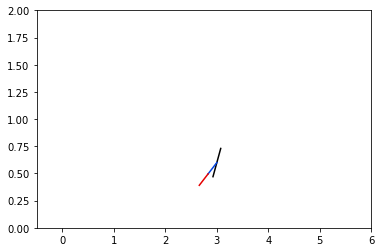

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

#rb = sym.Matrix([[x],
#                [z]])

#rl1 = sym.Matrix([[x + (0.5*ll1)*sym.cos(thl)],
#                 [z - (0.5*ll1)*sym.sin(thl)]])

#rl2 = sym.Matrix([[x + (0.5*ll1 + r)*sym.cos(thl)],
#                 [z - (0.5*ll1 + r)*sym.sin(thl)]])

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,6])
    ax.set_ylim([0,2])
    
    #plot body
    body_xb = m.q0[i,'x'].value - 0.5*m.lb*cos(m.q0[i,'theta_b'].value)
    body_yb = m.q0[i,'z'].value - 0.5*m.lb*sin(m.q0[i,'theta_b'].value)
    body_xf = m.q0[i,'x'].value + 0.5*m.lb*cos(m.q0[i,'theta_b'].value)
    body_yf = m.q0[i,'z'].value + 0.5*m.lb*sin(m.q0[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
    
    #plot leg 
    leg_xt1 = m.q0[i,'x'].value 
    leg_yt1 = m.q0[i,'z'].value 
    leg_xb1 = m.q0[i,'x'].value + m.ll1*cos(m.q0[i,'theta_l'].value)
    leg_yb1 = m.q0[i,'z'].value - m.ll1*sin(m.q0[i,'theta_l'].value)
    ax.plot([leg_xt1,leg_xb1],[leg_yt1,leg_yb1],color='xkcd:blue')
    
    #plot leg 
    leg_xt = m.q0[i,'x'].value + m.ll1*cos(m.q0[i,'theta_l'].value) 
    leg_yt = m.q0[i,'z'].value - m.ll1*sin(m.q0[i,'theta_l'].value)
    leg_xb = m.q0[i,'x'].value + (m.ll1 + m.q0[i,'r'].value)*cos(m.q0[i,'theta_l'].value)
    leg_yb = m.q0[i,'z'].value - (m.ll1 + m.q0[i,'r'].value)*sin(m.q0[i,'theta_l'].value)
    ax.plot([leg_xt,leg_xb],[leg_yt,leg_yb],color='xkcd:red')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

HTML(animate.to_jshtml())
#HTML(animate.to_html5_video())

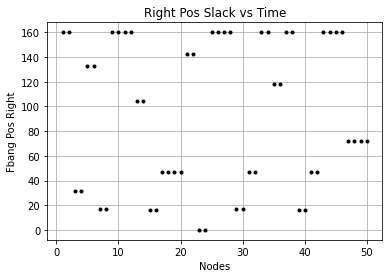

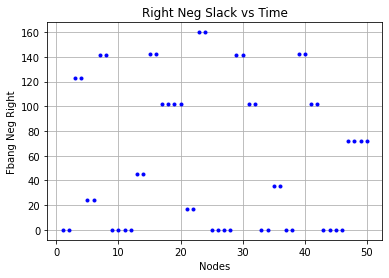

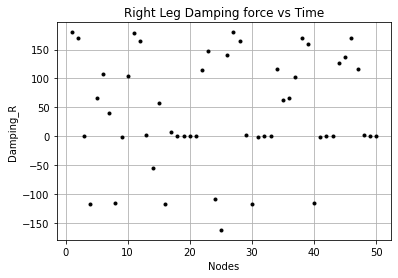

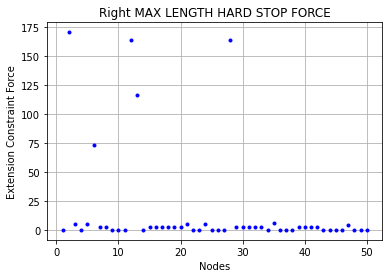

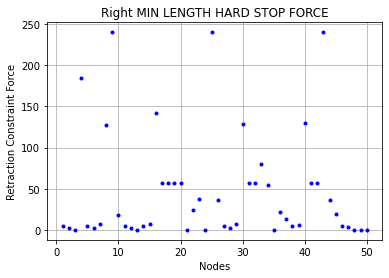

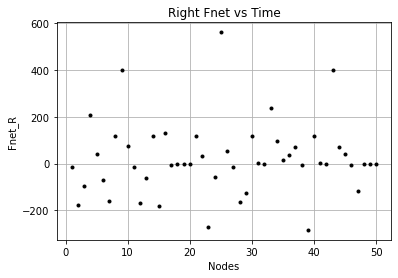

In [24]:
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    posSlack_R = m.F_max*m.Fbang_pos[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,posSlack_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fbang Pos Right')
    plt.title('Right Pos Slack vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    negSlack_R = m.F_max*m.Fbang_neg[n].value
    time = m.tt0[n].value
    Time += time

    plt.plot(n,negSlack_R,'k.',c='blue')
    plt.xlabel('Nodes')
    plt.ylabel('Fbang Neg Right')
    plt.title('Right Neg Slack vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.dq0[n,'r'].value*m.damping
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Damping_R')
    plt.title('Right Leg Damping force vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range(1,N+1):
    ext_force = m.FhardStop_ext[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Extension Constraint Force')
    plt.title('Right MAX LENGTH HARD STOP FORCE')
plt.show() 
    
plt.axes()
plt.grid(True)
Time = 0
for n in range(1,N+1):
    ext_force = m.FhardStop_rtn[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Retraction Constraint Force')
    plt.title('Right MIN LENGTH HARD STOP FORCE')    
plt.show()    
    
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.F_max*(m.Fbang_pos[n].value - m.Fbang_neg[n].value) - m.dq0[n,'r'].value*m.damping - m.FhardStop_ext[n].value + m.FhardStop_rtn[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fnet_R')
    plt.title('Right Fnet vs Time')
plt.show()

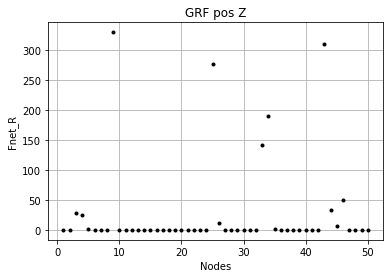

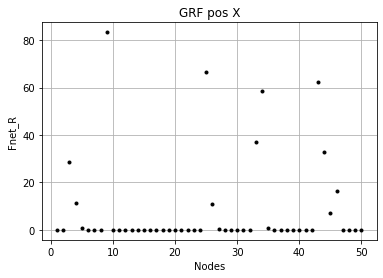

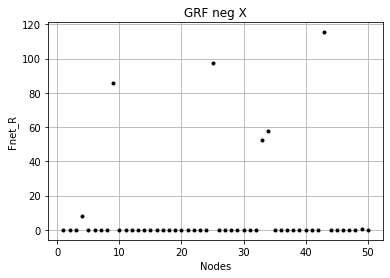

In [25]:
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.GRF[n,c,'Z','ps'].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fnet_R')
    plt.title('GRF pos Z')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.GRF[n,c,'X','ps'].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fnet_R')
    plt.title('GRF pos X')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.GRF[n,c,'X','ng'].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fnet_R')
    plt.title('GRF neg X')
plt.show()

In [26]:
'''from numpy import asarray
from numpy import save

data = asarray([[N for n in range (1, N+1)],
                [m.lb.value for n in range (1, N+1)],
                [m.lb.value for n in range(1, N+1)],
                [m.tau_a[n].value for n in range (1, N+1)],
                [m.F_a[n].value for n in range (1, N+1)],
                [m.q0[n,'theta_l'].value for n in range (1, N+1)],
                [m.q0[n,'r'].value for n in range (1, N+1)],
                [m.q0[n,'x'].value for n in range (1, N+1)],
                [m.q0[n,'z'].value for n in range (1, N+1)]])
save('data.npy', data)'''



"from numpy import asarray\nfrom numpy import save\n\ndata = asarray([[N for n in range (1, N+1)],\n                [m.lb.value for n in range (1, N+1)],\n                [m.lb.value for n in range(1, N+1)],\n                [m.tau_a[n].value for n in range (1, N+1)],\n                [m.F_a[n].value for n in range (1, N+1)],\n                [m.q0[n,'theta_l'].value for n in range (1, N+1)],\n                [m.q0[n,'r'].value for n in range (1, N+1)],\n                [m.q0[n,'x'].value for n in range (1, N+1)],\n                [m.q0[n,'z'].value for n in range (1, N+1)]])\nsave('data.npy', data)"